In [14]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD
import math
import pickle
import pandas
from sklearn.metrics import mean_squared_error

# Andiamo a costruire il modello LSTM

In [15]:
# Some functions to help out with
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Real IBM Stock Price')
    plt.plot(predicted, color='blue',label='Predicted IBM Stock Price')
    plt.title('IBM Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('IBM Stock Price')
    plt.legend()
    plt.show()

def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))


(150, 1)


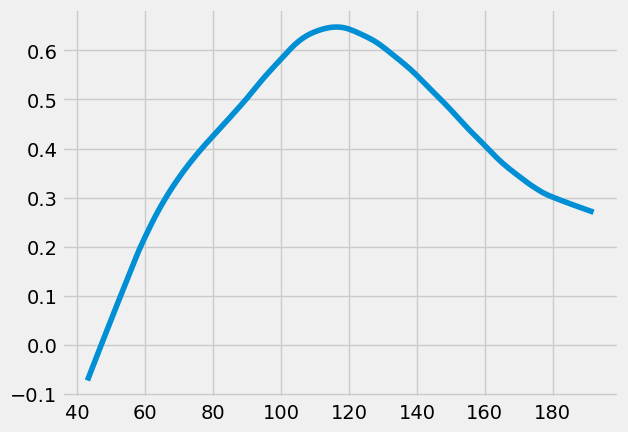

In [16]:
with open('hdvi.pickle', 'rb') as handle:
    NDVI = pickle.load(handle)
print()
NDVI[30].plot()

dataset = np.reshape(NDVI[30].data_matrix.flatten(),(NDVI[30].data_matrix.flatten().shape[0],1))
#pd.read_csv('IBM_2006-01-01_to_2018-01-01.csv', index_col='Date', parse_dates=['Date'])

print(dataset.shape)

In [17]:
# Checking for missing values dataset[:'2016'].iloc[:,1:2].values
trainingLenght = 120
testLenght = 30

training_set = dataset[:trainingLenght]
print(training_set.shape)
print(len(training_set))
test_set = dataset[trainingLenght:]
print(test_set.shape)
print(len(test_set))

(120, 1)
120
(30, 1)
30


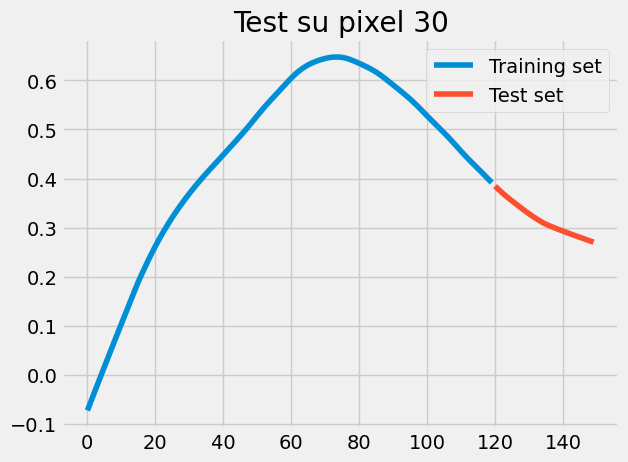

In [18]:
s = pd.Series(dataset.flatten())
s[:trainingLenght].plot(legend=True)
s[trainingLenght:].plot(legend=True)
plt.legend(['Training set','Test set'])
plt.title('Test su pixel 30')
plt.show()

In [19]:
# Scaling the training set
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)

In [20]:
# Since LSTMs store long term memory state, we create a data structure with 60 timesteps and 1 output
# So for each element of training set, we have 60 previous training set elements 
Window = 10
X_train = []
y_train = []
for i in range(Window,trainingLenght):
    X_train.append(training_set_scaled[i-Window:i,0])
    y_train.append(training_set_scaled[i,0])
    '''print(training_set_scaled[i-60:i,0])
    print(training_set_scaled[i,0])'''
X_train, y_train = np.array(X_train), np.array(y_train)
print(X_train[2])

[0.0497174  0.07444644 0.09908683 0.12363859 0.14810157 0.17247447
 0.19675603 0.22095236 0.24507219 0.26912569]


In [21]:
# Reshaping X_train for efficient modelling
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))
print(X_train.shape)
print(y_train.shape)

(110, 10, 1)
(110,)


In [22]:
# The LSTM architecture
regressor = Sequential()
# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.2))
# Second LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Third LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Fourth LSTM layer
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))
# The output layer
regressor.add(Dense(units=1))

In [23]:
# Compiling the RNN
regressor.compile(optimizer='rmsprop',loss='mean_squared_error')

# Fitting to the training set
regressor.fit(X_train,y_train,epochs=50,batch_size=32)

Epoch 1/50
4/4 [==============================] - 6s 16ms/step - loss: 0.4203
Epoch 2/50
4/4 [==============================] - 0s 15ms/step - loss: 0.0188
Epoch 3/50
4/4 [==============================] - 0s 15ms/step - loss: 0.0335
Epoch 4/50
4/4 [==============================] - 0s 14ms/step - loss: 0.0233
Epoch 5/50
4/4 [==============================] - 0s 14ms/step - loss: 0.0113
Epoch 6/50
4/4 [==============================] - 0s 15ms/step - loss: 0.0189
Epoch 7/50
4/4 [==============================] - 0s 14ms/step - loss: 0.0121
Epoch 8/50
4/4 [==============================] - 0s 14ms/step - loss: 0.0382
Epoch 9/50
4/4 [==============================] - 0s 15ms/step - loss: 0.0096
Epoch 10/50
4/4 [==============================] - 0s 14ms/step - loss: 0.0200
Epoch 11/50
4/4 [==============================] - 0s 14ms/step - loss: 0.0173
Epoch 12/50
4/4 [==============================] - 0s 14ms/step - loss: 0.0151
Epoch 13/50
4/4 [==============================] - 0s 14ms/st

In [24]:
# Now to get the test set ready in a similar way as the training set.
# The following has been done so forst 60 entires of test set have 60 previous values which is impossible to get unless we take the whole 
# 'High' attribute data for processing
dataset_total = pd.concat((s[:trainingLenght],s[trainingLenght:]),axis=0)
inputs = dataset_total[len(dataset_total)-len(test_set)-Window:].values # Da qui ho tolto - 10
inputs = dataset_total[len(dataset_total)-len(test_set)-Window:].values # Da qui ho tolto - 10
inputs = inputs.reshape(-1,1)
inputs  = sc.fit_transform(inputs)

In [25]:
# Preparing X_test and predicting the prices

X_test = []
#X_test = dataset_total[len(dataset_total)-2*Window:-Window]
for i in range(Window,testLenght+Window):
    X_test.append(inputs[i-Window:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (1,Window,1))
print(X_test.shape)
predicted_stock_price = regressor.predict(X_test)

predicted_stock_price = sc.inverse_transform(predicted_stock_price)
print(predicted_stock_price)

ValueError: cannot reshape array of size 300 into shape (1,10,1)

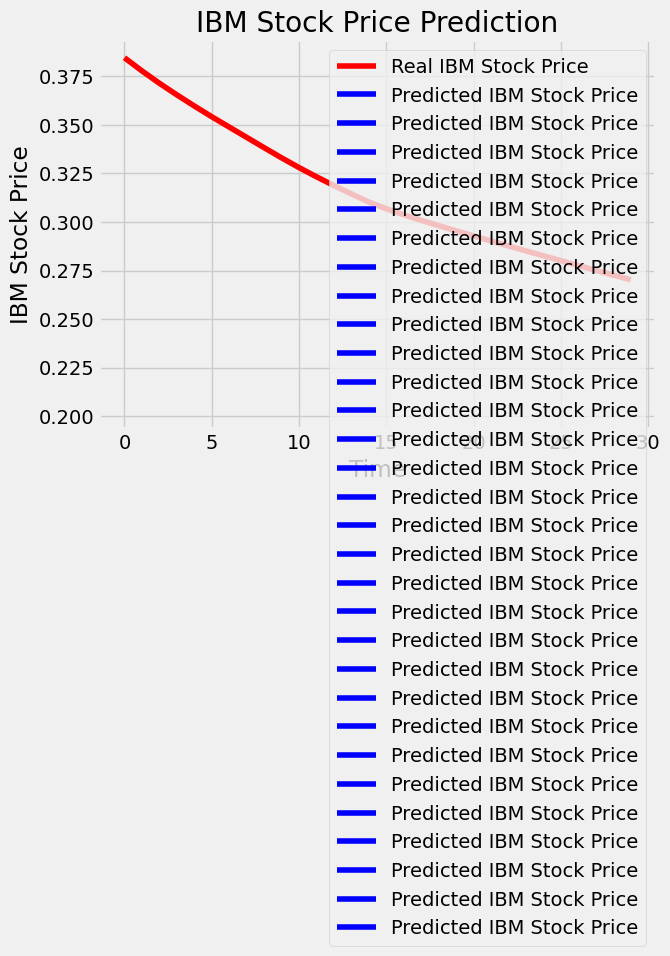

In [ ]:
# Visualizing the results for LSTM
#plot_predictions(test_set,predicted_stock_price)


Epoch 1/60
2/2 [==============================] - 8s 2s/step - loss: 0.7092 - val_loss: 0.6234
Epoch 2/60
2/2 [==============================] - 0s 189ms/step - loss: 0.5663 - val_loss: 0.3178
Epoch 3/60
2/2 [==============================] - 0s 189ms/step - loss: 0.2689 - val_loss: 0.1517
Epoch 4/60
2/2 [==============================] - 0s 196ms/step - loss: 0.1304 - val_loss: 0.0719
Epoch 5/60
2/2 [==============================] - 0s 193ms/step - loss: 0.0613 - val_loss: 0.0357
Epoch 6/60
2/2 [==============================] - 0s 192ms/step - loss: 0.0324 - val_loss: 0.0259
Epoch 7/60
2/2 [==============================] - 0s 201ms/step - loss: 0.0253 - val_loss: 0.0250
Epoch 8/60
2/2 [==============================] - 0s 189ms/step - loss: 0.0256 - val_loss: 0.0270
Epoch 9/60
2/2 [==============================] - 0s 189ms/step - loss: 0.0271 - val_loss: 0.0280
Epoch 10/60
2/2 [==============================] - 0s 195ms/step - loss: 0.0277 - val_loss: 0.0266
Epoch 11/60
2/2 [====

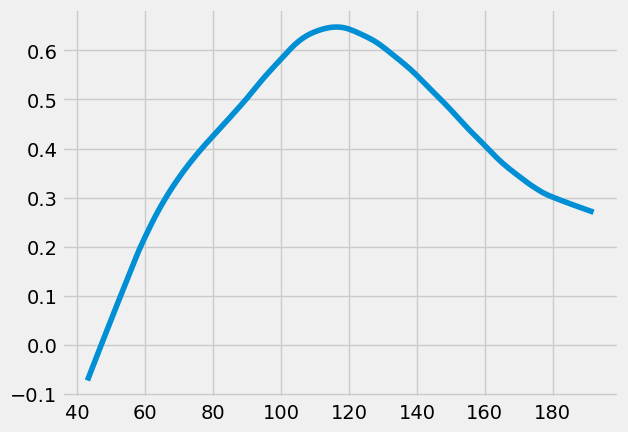

In [188]:
# Now to get the test set ready in a similar way as the training set.
# The following has been done so forst 60 entires of test set have 60 previous values which is impossible to get unless we take the whole 
# 'High' attribute data for processing
# generate the input and output sequences
with open('hdvi.pickle', 'rb') as handle:
    NDVI = pickle.load(handle)
print()
NDVI[30].plot()

# Scaling the training set
sc = MinMaxScaler(feature_range=(0,1))

datasetTrain = np.reshape(NDVI.mean().data_matrix.flatten(),(NDVI.mean().data_matrix.flatten().shape[0],1))
datasetTrain = sc.fit_transform(datasetTrain)
datasetTrain = datasetTrain.reshape(-1, 1)

datasetTest = np.reshape(NDVI[30].data_matrix.flatten(),(NDVI[30].data_matrix.flatten().shape[0],1))
datasetTest = sc.fit_transform(datasetTest)
datasetTest = datasetTest.reshape(-1, 1)

n_lookback = 30  # length of input sequences (lookback period)
n_forecast = 60  # length of output sequences (forecast period)

X = []
Y = []
for i in range(n_lookback, len(datasetTrain) - n_forecast + 1):
    X.append(datasetTrain[i - n_lookback: i])
    Y.append(datasetTrain[i: i + n_forecast])
X = np.array(X)
Y = np.array(Y)

X_val = []
Y_val = []
for i in range(n_lookback, len(datasetTrain) - n_forecast + 1):
    X_val.append(datasetTest[i - n_lookback: i])
    Y_val.append(datasetTest[i: i + n_forecast])
X_val = np.array(X_val)
Y_val = np.array(Y_val)

Nepoch = 60
# The LSTM architecture
regressor = Sequential()
regressor.add(LSTM(units=60, return_sequences=True, input_shape=(n_lookback,1)))
regressor.add(LSTM(units=120, return_sequences=True))
regressor.add(LSTM(units=240, return_sequences=True))
regressor.add(LSTM(units=120))
# The output layer
regressor.add(Dense(n_forecast))

regressor.compile(loss='mean_squared_error', optimizer='adam')
history = regressor.fit(X, Y, epochs=Nepoch,validation_data=(X_val,Y_val), batch_size=32,use_multiprocessing=True)


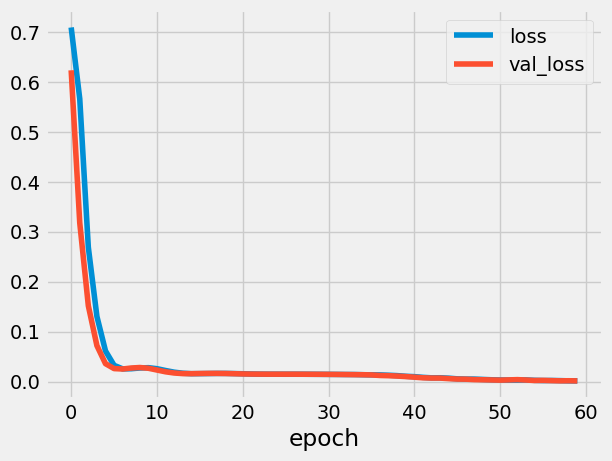

In [189]:
history_df = pd.DataFrame(columns=['epoch', 'loss'])
history_df['epoch'] = range(Nepoch)
history_df['loss'] = history.history['loss']
history_df['val_loss'] = history.history['val_loss']
history_df = history_df.set_index('epoch')
history_df.plot()

In [190]:


dataset_total = np.reshape(NDVI[90].data_matrix.flatten(),(NDVI[90].data_matrix.flatten().shape[0],1))
starttime = 10
stoptime = starttime+n_lookback
inputs = dataset_total[starttime:stoptime] # generare "l'ultima sequenza disponibile"
print(inputs[-3:])
inputs  = sc.transform(inputs)
inputs = inputs.reshape(1, n_lookback, 1)

predicted_stock_price = regressor.predict(inputs)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
print(predicted_stock_price[0][:3])

[[0.43149203]
 [0.43880832]
 [0.44618876]]
1/1 [==============================] - 1s 1s/step
[0.4422391  0.45330134 0.451277  ]


C:\Users\Leo\AppData\Local\Temp\ipykernel_9256\3659863215.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = df_past.append(df_future).set_index('Date')


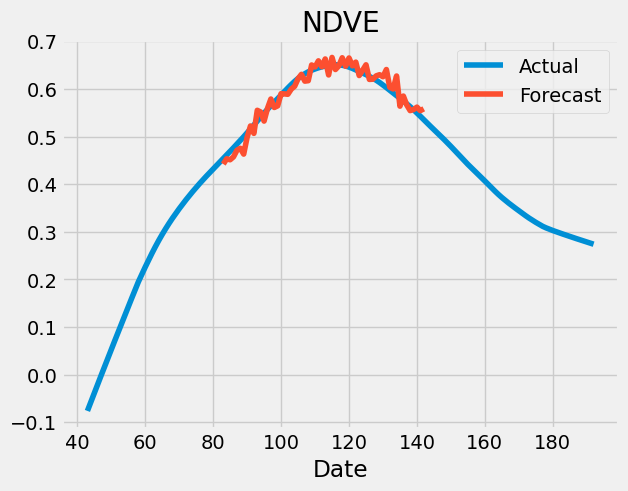

In [191]:
# organize the results in a data frame
Days = range(43,193)
df_past = pd.DataFrame(columns=['Date', 'Actual'])
df_past['Date'] = Days
df_past['Actual'] = dataset_total

df_future = pd.DataFrame(columns=['Date', 'Actual', 'Forecast'])
df_future['Date'] = Days[stoptime:stoptime+n_forecast]
df_future['Forecast'] = predicted_stock_price.flatten() #ha offset di 0.2 ma non si sa perche' :/ 

results = df_past.append(df_future).set_index('Date')
results.plot(title='NDVE')

In [ ]:
# Evaluating our model
print(test_set.shape)
print(predicted_stock_price.shape)
return_rmse(test_set,predicted_stock_price)

(30, 1)
(30, 1)
The root mean squared error is 0.077805492893546.


# Andiamo a costruire il modello GRU

Epoch 1/60


c:\Users\Leo\.conda\envs\Agrivision\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1/1 [==============================] - 8s 8s/step - loss: 0.7203 - val_loss: 0.7144
Epoch 2/60
1/1 [==============================] - 0s 129ms/step - loss: 0.7165 - val_loss: 0.7101
Epoch 3/60
1/1 [==============================] - 0s 128ms/step - loss: 0.7131 - val_loss: 0.7041
Epoch 4/60
1/1 [==============================] - 0s 127ms/step - loss: 0.7076 - val_loss: 0.6965
Epoch 5/60
1/1 [==============================] - 0s 122ms/step - loss: 0.7000 - val_loss: 0.6877
Epoch 6/60
1/1 [==============================] - 0s 121ms/step - loss: 0.6913 - val_loss: 0.6776
Epoch 7/60
1/1 [==============================] - 0s 123ms/step - loss: 0.6807 - val_loss: 0.6667
Epoch 8/60
1/1 [==============================] - 0s 120ms/step - loss: 0.6703 - val_loss: 0.6549
Epoch 9/60
1/1 [==============================] - 0s 125ms/step - loss: 0.6594 - val_loss: 0.6424
Epoch 10/60
1/1 [==============================] - 0s 131ms/step - loss: 0.6463 - val_loss: 0.6294
Epoch 11/60
1/1 [================

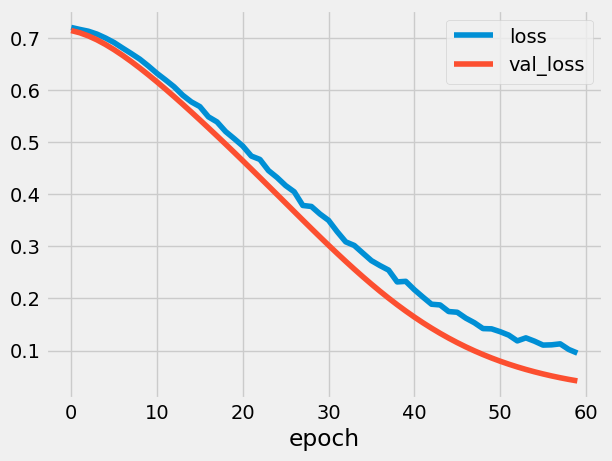

In [216]:
# The GRU architecture
Nepoch = 150
regressorGRU = Sequential()
# First GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True,input_shape=(n_lookback,1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
regressorGRU.add(GRU(units=50, return_sequences=True,input_shape=(n_lookback,1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
regressorGRU.add(GRU(units=50, return_sequences=True,input_shape=(n_lookback,1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
regressorGRU.add(GRU(units=50, activation='tanh'))
regressorGRU.add(Dropout(0.2))
regressorGRU.add(Dense(units=n_forecast))
regressorGRU.compile(optimizer=SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error')
# Fitting to the training set
gruHistory = regressorGRU.fit(X,Y,epochs=Nepoch,validation_data=(X_val,Y_val),batch_size=150)

history_df = pd.DataFrame(columns=['epoch', 'loss'])
history_df['epoch'] = range(Nepoch)
history_df['loss'] = gruHistory.history['loss']
history_df['val_loss'] = gruHistory.history['val_loss']
history_df = history_df.set_index('epoch')
history_df.plot()

[[0.43149203]
 [0.43880832]
 [0.44618876]]
1/1 [==============================] - 1s 1s/step
[0.5700977  0.6512323  0.67695373]


C:\Users\Leo\AppData\Local\Temp\ipykernel_9256\4081375764.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = df_past.append(df_future).set_index('Date')


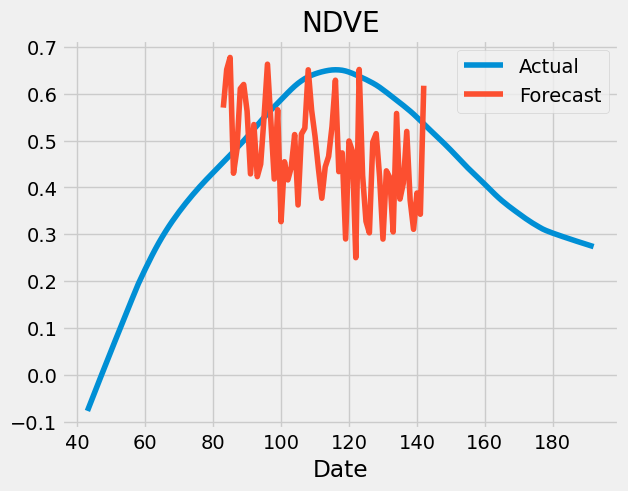

In [217]:
dataset_total = np.reshape(NDVI[90].data_matrix.flatten(),(NDVI[90].data_matrix.flatten().shape[0],1))
starttime = 10
stoptime = starttime+n_lookback
inputs = dataset_total[starttime:stoptime] # generare "l'ultima sequenza disponibile"
print(inputs[-3:])
inputs  = sc.transform(inputs)
inputs = inputs.reshape(1, n_lookback, 1)

predicted_stock_price = regressorGRU.predict(inputs)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
print(predicted_stock_price[0][:3])

# organize the results in a data frame
Days = range(43,193)
df_past = pd.DataFrame(columns=['Date', 'Actual'])
df_past['Date'] = Days
df_past['Actual'] = dataset_total

df_future = pd.DataFrame(columns=['Date', 'Actual', 'Forecast'])
df_future['Date'] = Days[stoptime:stoptime+n_forecast]
df_future['Forecast'] = predicted_stock_price.flatten() #ha offset di 0.2 ma non si sa perche' :/ 

results = df_past.append(df_future).set_index('Date')
results.plot(title='NDVE')